# EE 511 Assignment 2 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [26]:
import tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

tools.check_sklearn_version()

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## \[Step 3\] Load training, validation and testing data

In [2]:
train, valid, test = tools.load_data()

## \[Step 4\] One variable least squares linear regression 

In [3]:
area_label = 'Gr Liv Area'
price_label = 'SalePrice'

area_train = train[area_label].to_numpy()
area_valid = valid[area_label].to_numpy()
area_test = test[area_label].to_numpy()
price_train = train[price_label].to_numpy()
price_valid = valid[price_label].to_numpy()
price_test = test[price_label].to_numpy()

In [4]:
small_model = LinearRegression().fit(area_train.reshape(-1, 1), price_train)

Text(0.5, 1.0, 'Sale Price vs. Gr Liv Area - Linear Regression')

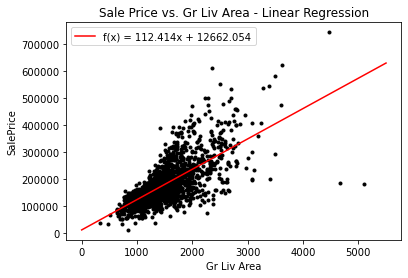

In [5]:
x = np.linspace(0, 5500, 100)
y = small_model.coef_[0] * x + small_model.intercept_

plt.xlabel(area_label)
plt.ylabel(price_label)
plt.plot(area_train, price_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (small_model.coef_[0], small_model.intercept_))
plt.legend()
plt.title('Sale Price vs. Gr Liv Area - Linear Regression')

In [6]:
price_predicted = small_model.predict(area_valid.reshape(-1, 1))
print("RMSE = $%.2f" % mean_squared_error(price_valid, price_predicted, squared=False))

RMSE = $56299.05


## \[Step 5\] Adding more features to the simple model

In [11]:
train_without_price = train.drop(price_label, 1).to_numpy()
valid_without_price = valid.drop(price_label, 1).to_numpy()

In [12]:
large_model = LinearRegression().fit(train_without_price, price_train)
pred = large_model.predict(valid_without_price)
print("RMSE = $%.2f" % mean_squared_error(price_valid, pred, squared=False))

RMSE = $26700.24


## \[Step 6\] Adding L1 regularization

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
this will come in handy